## Installations

We will start by running a couple of pip installers. Skip this part if you have the libraries installed in your environment.

In [1]:
!pip install torch
!pip install crabnet
!pip install pandas
!pip install jmespath
!pip install numpy

## Load data 

In the previous part, we retrieved perovskite solar cell data using the NOMAD API, converted it to a Pandas DataFrame, and saved it as **perovskite_bandgap_devices.csv** in the **data** folder. If you already have the data, you can start from this section, where we will import and clean it.

The distribution of the chemical diveristy of the dataset can be viewed in the dynamic periodioc table of the NOMAD entries explorer. The down right corner of every element shows the number of entries (solar cells) that contain in the absorber a given element. It becomes obvius that the data set is imbalance with the majority of the entries being *Pb* based, containing *C*, *N* anf *H* (hybrid perovskites) and mostly halide compounds, with most of the entries having *I* and/or *Br*. 

In [107]:
import pandas as pd

df_pvk = pd.read_csv('data/perovskite_bandgap_devices.csv')
df_chalcogenides = pd.read_csv('data/chalcogenides_bandgap_devices.csv')
df_chalc_semicon = pd.read_csv('data/chalcogen_semicon_bandgap.csv')
for df_, sc in zip([df_pvk, df_chalcogenides, df_chalc_semicon], ['pvk', 'chalcogenides', 'chalc_semicon']):
    df_['source'] = sc
df = pd.concat([df_pvk, df_chalcogenides, df_chalc_semicon])
sources = (x*100/df.shape[0] for x in [df_pvk.shape[0], df_chalcogenides.shape[0], df_chalc_semicon.shape[0]])
txt = 'The data comes from the following sources:\n{0:.2f} % from halide perovskites,\n{1:.4f} % from chalcogenides perovskites,\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df.head()

The data comes from the following sources:
70.28 % from halide perovskites,
0.0277 % from chalcogenides perovskites,
29.70 % from chalcogenide semiconductors


,reduced_formulas,descriptive_formulas,bandgap,source
0,CH6I3NPb,MAPbI3,1.6,pvk
1,CH6I3NPb,MAPbI3,NaN,pvk
2,CH6I3NPb,MAPbI3,1.5,pvk
3,CH6I3NPb,MAPbI3,1.6,pvk
4,CH6I3NPb,MAPbI3,1.6,pvk


## EDA & Data Cleaning

Exploratory Data Analysis (EDA) is a useful step in understanding and preparing datasets for modeling by summarizing data, checking for anomalies, finding patterns and relationships.

### Insights from NOMAD GUI

The distribution of chemical diversity of the dataset can be explored using the [periodic table in the NOMAD solar cell app](https://nomad-lab.eu/prod/v1/gui/search/solarcells). The bottom-right corner of each element displays the number of entries (solar cells) that include the element in the absorber. The dataset is notably imbalanced, with the majority of entries being Pb-based, containing C, N, H (hybrid perovskites), and halides like I and Br.

Let's have a look on the statistical summary of the dataset:

In [74]:
df.describe()

,bandgap
count,50686.000000
mean,1.713245
std,0.602313
min,0.000200
25%,1.590000
50%,1.600000
75%,1.670000
max,18.000000


We can see that the dataset contains a diverse range of bandgap values (1.16 to 3.05 eV). Some parameters such as open circuit voltage (voc) and fill factor (ff), include extreme or zero values, which might need attention for data cleaning.

### Remove NaNs

The dataset might include missing values, let's check if there are any:

In [11]:
df.isna().sum()

reduced_formulas          577
descriptive_formulas      577
bandgap                 10654
dtype: int64

 Let's now keep only the part of the dataframe, where the value for bandgap is not Na.

In [12]:
df = df[df['bandgap'].notna()]
df = df[df['reduced_formulas'].notna()]

In [13]:
df.isna().sum()

reduced_formulas        0
descriptive_formulas    0
bandgap                 0
dtype: int64

### Group Repeated Formulas

Even before checking the dataset, we can already guess that are many repeated formulas and bandgap values in the DataFrame. But let's verify it:

In [14]:
df['reduced_formulas'].value_counts().head(10)


reduced_formulas
CH6I3NPb     26474
Cd1S1         2200
Mo1S2         1492
Zn1S1         1204
Cd1Se1         590
CH5I3N2Pb      569
Pb1S1          525
Zn1Se1         406
Sn1S1          355
Se1            310
Name: count, dtype: int64

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [85]:
from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the mean of the target
df_grouped_formula = groupby_formula(df, how='mean')
df_grouped_formula.head()


,formula,index,target
0,Ag0.22In0.22Zn1S2,"(3076, 3541)",2.30
1,Ag0.25Cu0.75In0.2Ga0.8Se2,"(9511,)",0.07
2,Ag0.5Eu1Ge1S4,"(17469,)",2.14
3,Ag0.5Pb1Ge1S4,"(3518, 17470)",1.83
4,Ag0.5Pb1Ge1Se4,"(17471,)",1.51


Let's check the shape of the DataFrame we would like to use for our ML:

In [106]:
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalcogenides', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.4f} % from chalcogenides perovskites,' \
      '\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

The shape of the DataFrame is:  (4483, 4)
After cleaning and groupin the data, the sources percentages are:
41.85 % from halide perovskites,
0.2454 % from chalcogenides perovskites,
57.91 % from chalcogenide semiconductors


### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

<Axes: >

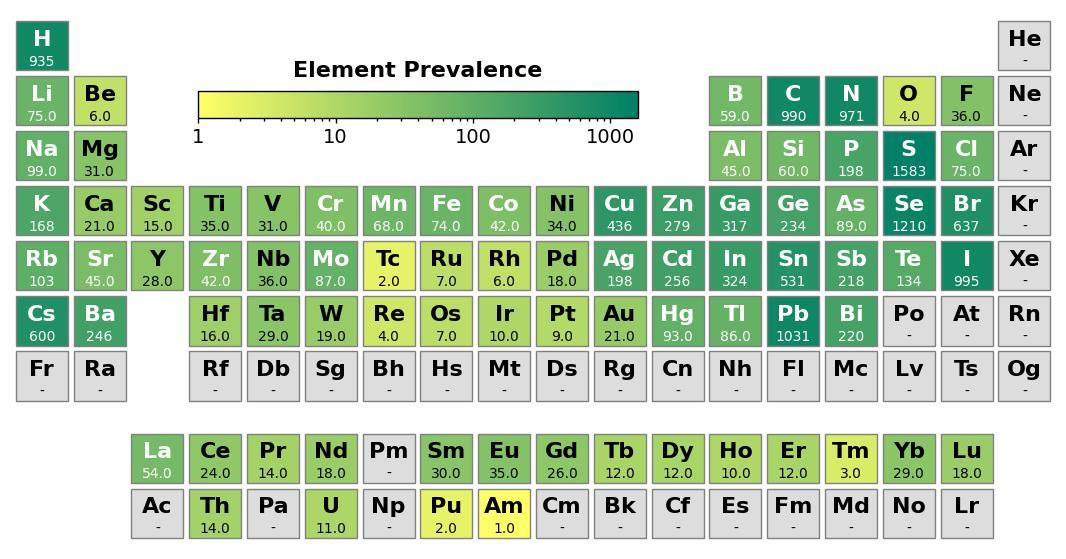

In [61]:
from pymatviz import count_elements, ptable_heatmap
import re

element_counts = count_elements([re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped_formula['formula']])

# Plot the periodic table heatmap
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')

Let's continue and build the model in the next section!

## Build and Fit the Model 

We randomize the dataset and split it into training, validation, and test sets in a ratio of 80%, 10%, and 10%, respectively.

In [18]:
import numpy as np

train_df, val_df, test_df = np.split(
    df_grouped_formula.sample(frac=1, random_state=42),
    [
        int(0.8 * len(df_grouped_formula)),
        int(0.9 * len(df_grouped_formula))
    ]
)

We then fit the model using the CrabNet implementation.


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/TF-ChPVK-PV/.conda/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2884/2884 [00:00<00:00, 144076.48formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 360/360 [00:00<00:00, 237152.42formulae/s]


loading data with up to 8 elements in the formula
stepping every 230 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.573 val mae: 0.64


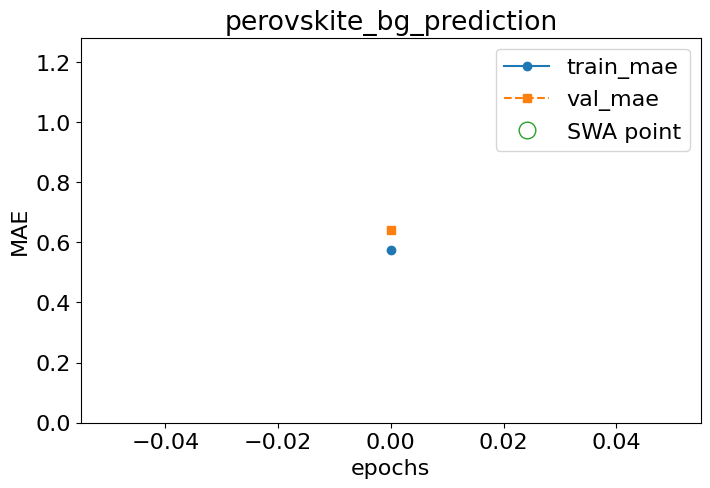

Epoch: 19/300 --- train mae: 0.269 val mae: 0.401


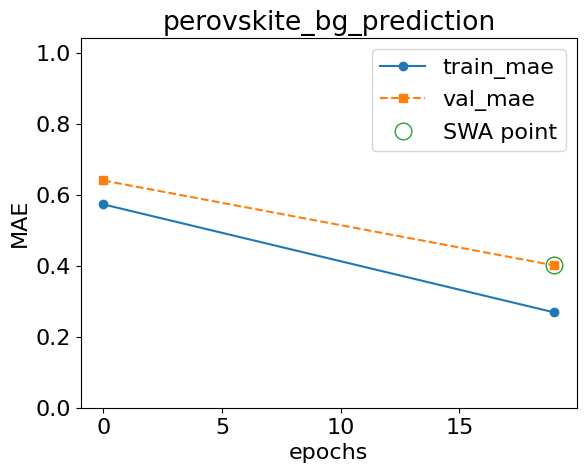

Epoch: 39/300 --- train mae: 0.175 val mae: 0.388


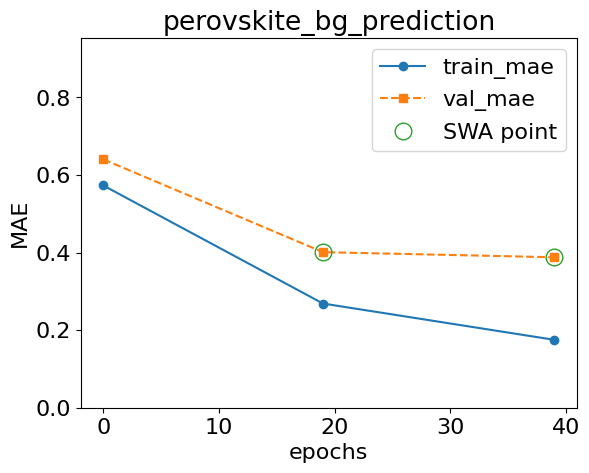

Epoch: 59/300 --- train mae: 0.123 val mae: 0.39


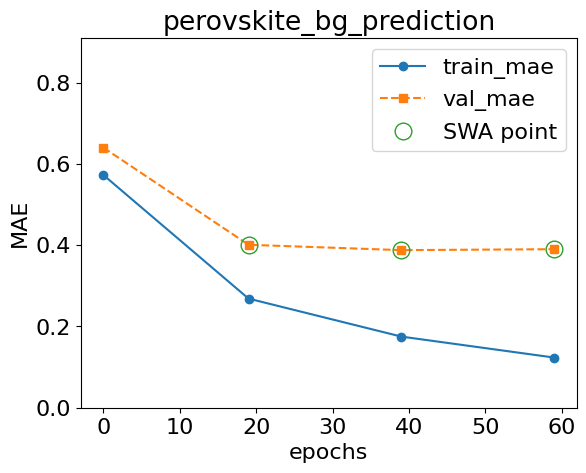

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0916 val mae: 0.395


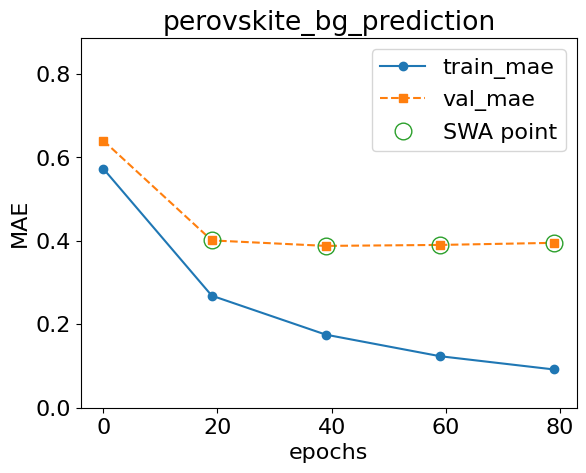

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 0.0723 val mae: 0.394


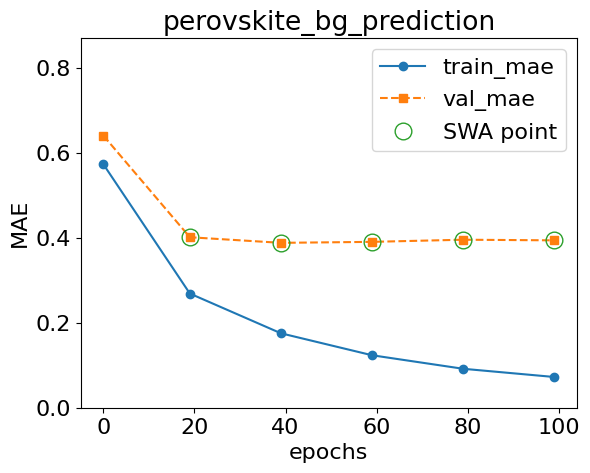

Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 0.0598 val mae: 0.396


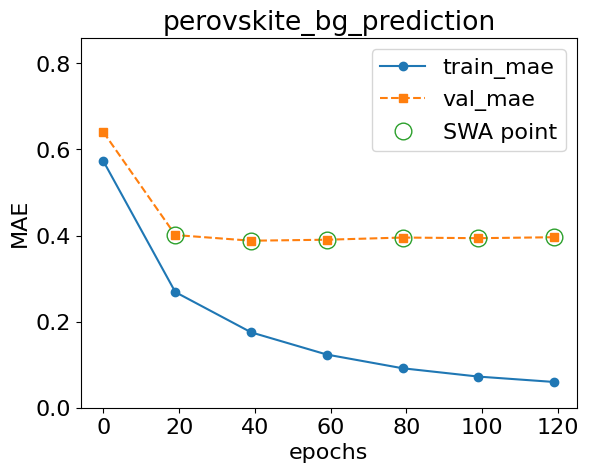

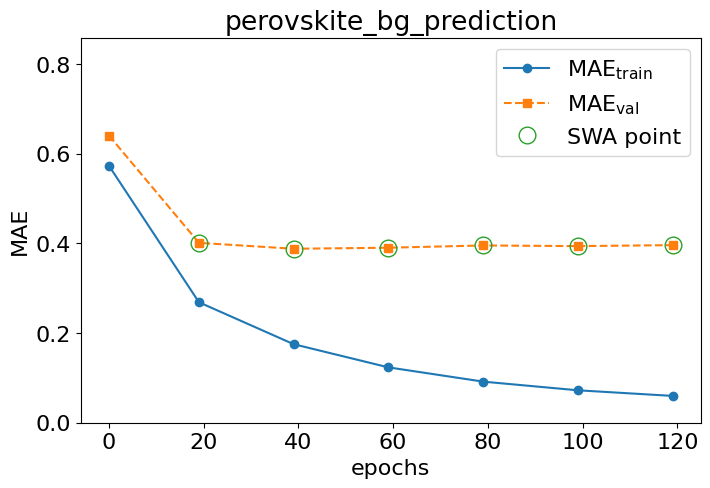

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [19]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.

Generating EDM: 100%|██████████| 2884/2884 [00:00<00:00, 223308.03formulae/s]


loading data with up to 8 elements in the formula


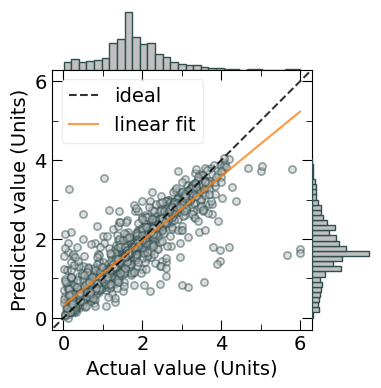

R2 score: 0.8204055366543155
MSE: 0.10913926193973894
MAE: 0.13461083850649339 eV


In [20]:
from crabnet.utils.figures import act_pred  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train data
train_df_zeros = pd.DataFrame({"formula": train_df['formula'], "target": [0.0]*len(train_df['formula'])})
train_df_predicted, train_df_predicted_sigma = crabnet_bandgap.predict(train_df_zeros, return_uncertainty=True)

act_pred(train_df['target'], train_df_predicted)
r2 = r2_score(train_df['target'], train_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(train_df['target'], train_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(train_df['target'], train_df_predicted)
print(f'MAE: {mae} eV')

for validation data we have:

Generating EDM: 100%|██████████| 360/360 [00:00<00:00, 201219.28formulae/s]

loading data with up to 8 elements in the formula


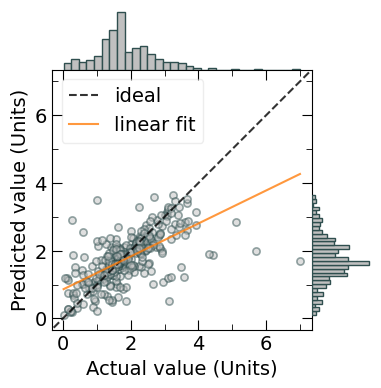

R2 score: 0.39355484283239894
MSE: 0.48123888026881223
MAE: 0.38976409940915346 eV


In [21]:
# Validation data
val_df_zeros = pd.DataFrame({"formula": val_df['formula'], "target": [0.0]*len(val_df['formula'])})
val_df_predicted, val_df_predicted_sigma = crabnet_bandgap.predict(val_df_zeros, return_uncertainty=True)

act_pred(val_df['target'], val_df_predicted)
r2 = r2_score(val_df['target'], val_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(val_df['target'], val_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(val_df['target'], val_df_predicted)
print(f'MAE: {mae} eV')

and finally for test data:

Generating EDM: 100%|██████████| 361/361 [00:00<00:00, 205614.31formulae/s]

loading data with up to 8 elements in the formula


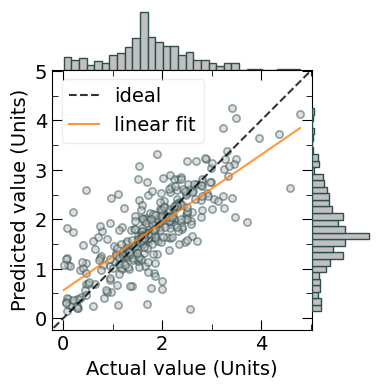

R2 score: 0.5652025794965989
MSE: 0.28726127519788225
MAE: 0.3545881998785861 eV


In [22]:
# Test data

test_df_zeros = pd.DataFrame({"formula": test_df['formula'], "target": [0.0]*len(test_df['formula'])})
test_df_predicted, test_df_predicted_sigma = crabnet_bandgap.predict(test_df_zeros, return_uncertainty=True)

act_pred(test_df['target'], test_df_predicted)

r2 = r2_score(test_df['target'], test_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(test_df['target'], test_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(test_df['target'], test_df_predicted)
print(f'MAE: {mae} eV')

## Predict Bandgap from Individual Formulas

Now we are ready to run some predictions using our trainned model. 
We will start loading the model just in case you want to start direcly here in a new session and the model weights are available.

In [23]:
import numpy as np
import pandas as pd  # only if you jump to this cell directly
from crabnet.crabnet_ import CrabNet  # type: ignore
from crabnet.kingcrab import SubCrab  # type: ignore

# Instantiate SubCrab
sub_crab_model = SubCrab()

# Instantiate CrabNet and set its model to SubCrab
crabnet_model = CrabNet()
crabnet_model.model = sub_crab_model

# Load the pre-trained network
file_path = r'perovskite_bg_prediction.pth'
crabnet_model.load_network(file_path)
crabnet_model.to('cuda')

/home/dagar/TF-ChPVK-PV/.conda/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/TF-ChPVK-PV/.conda/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary o


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


CrabNet(
  (model): SubCrab(
    (encoder): Encoder(
      (embed): Embedder(
        (fc_mat2vec): Linear(in_features=200, out_features=512, bias=True)
        (cbfv): Embedding(119, 200)
      )
      (prevalence_encoder): FractionalEncoder()
      (prevalence_log_encoder): FractionalEncoder()
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
            )
            (linear1): Linear(in_features=512, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=512, bias=True)
            (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
    

Then define a function and run it for predicting the bandgap from individual formulas:


In [24]:
# Function to predict the bandgap of a given formula
def predict_bandgap(formula):
    input_df = pd.DataFrame({"formula": [formula], "target": [0.0]})
    prediction, prediction_sigma = crabnet_model.predict(input_df, return_uncertainty=True)
    return prediction, prediction_sigma

In [25]:
df_compositions = pd.read_csv('data/stable_compositions.csv')
df_compositions.rename(columns={'Unnamed: 0': 'formula'}, inplace=True)
df_compositions.set_index('formula', inplace=True)
for formula in df_compositions.index:
    prediction, prediction_sigma = predict_bandgap(formula)
    df_compositions.loc[formula, 'bandgap'] = prediction
    df_compositions.loc[formula, 'bandgap_sigma'] = prediction_sigma

Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7626.01formulae/s]

loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7476.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8355.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4578.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9279.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11748.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6853.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13842.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4341.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6594.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9218.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4369.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8065.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4161.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5691.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2170.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6462.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8439.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2053.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4583.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6887.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6932.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8224.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3109.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5398.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4396.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6955.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4899.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6512.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3024.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4355.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5489.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4447.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7781.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5140.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7781.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4804.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10754.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6502.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5629.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4529.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8388.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5282.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5809.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3979.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5289.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4691.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3426.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5667.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6355.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6875.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1785.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5983.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5289.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4554.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8630.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4848.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3151.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9362.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11814.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9962.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6853.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6574.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1773.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3261.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5468.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3412.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3898.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4185.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10699.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6626.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5526.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5915.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6232.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4782.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3788.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5769.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12446.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3964.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10866.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3134.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7096.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5178.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7384.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8490.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6647.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9098.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7410.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5289.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9986.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11066.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8490.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5302.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5769.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2504.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5249.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9425.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2381.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5825.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5309.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5577.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4894.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6288.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6944.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6423.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4447.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6442.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6069.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13315.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5849.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5729.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1897.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3253.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6232.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5121.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5115.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6944.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 720.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5849.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2157.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3718.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3501.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5915.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2632.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4563.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2437.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5584.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13400.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6647.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3054.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8830.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5391.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10672.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4519.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6689.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4068.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6141.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2387.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9238.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5295.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5667.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4871.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13315.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8542.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2484.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3990.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 156.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4185.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2385.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4266.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6316.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 973.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6452.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5769.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3656.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5262.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5489.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2702.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6990.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5622.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4894.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6786.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4088.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5652.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4457.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10951.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4882.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8256.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5011.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12409.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3449.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8050.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6250.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8848.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2851.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8371.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7002.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6204.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9489.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8439.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5426.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6543.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5511.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6393.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4854.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3833.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1409.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2537.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1849.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6297.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2568.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1211.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4922.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10894.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4871.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5957.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8756.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3454.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5584.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12087.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4723.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5849.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9709.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12409.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6765.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9137.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7307.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5785.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5249.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5236.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7476.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6159.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6043.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4843.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6150.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4837.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5592.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4888.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6278.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4766.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5127.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5047.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4599.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5907.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3515.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4401.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7256.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3276.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4190.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3331.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13530.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6260.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6820.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1820.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4100.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5899.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11428.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5511.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5165.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4821.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6250.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12710.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4124.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12865.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5899.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5356.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5801.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5526.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8886.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5146.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5966.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6875.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6384.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5405.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6204.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10512.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4905.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6797.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7557.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4140.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6921.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3123.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5729.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3855.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5108.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4894.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4284.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8811.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5518.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4619.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10280.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1258.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10082.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1138.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5753.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9300.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7061.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3429.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2737.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2132.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 874.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5426.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6087.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3833.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10131.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5555.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6647.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5295.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2928.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5127.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1345.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11155.06formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7219.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8886.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5447.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5356.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4804.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1918.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8507.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9709.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6297.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3960.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11008.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5957.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4198.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6831.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6775.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7724.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5983.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 552.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1108.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5874.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9300.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5322.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7653.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10230.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1678.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7157.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6990.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5011.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4681.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8128.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6316.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4922.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5329.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6269.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5526.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3656.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4999.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2654.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4987.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13486.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6186.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6232.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3584.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4739.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5706.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12122.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9892.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5419.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9383.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8962.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10082.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8322.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7319.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6710.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6168.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1939.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4832.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6594.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8050.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5203.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4350.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5599.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6232.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5809.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10280.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1355.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8525.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5249.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5949.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16777.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9619.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1430.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10866.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9642.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5405.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9915.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4185.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5468.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2067.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9341.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4161.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6355.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6482.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4922.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12483.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10538.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7332.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9098.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2335.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10106.76formulae/s]


loading data with up to 3 elements in the formula


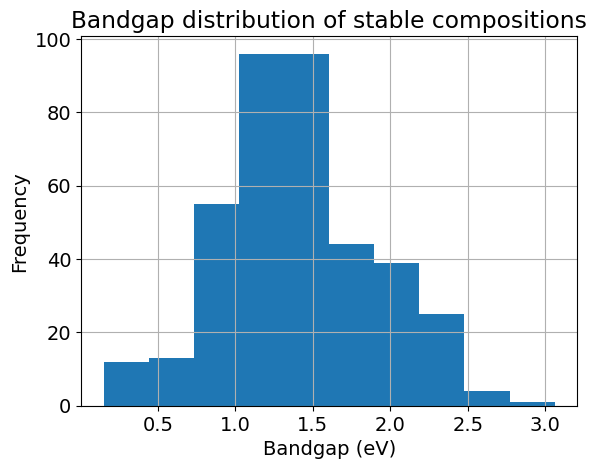

,bandgap,bandgap_sigma
formula,,
BaPbS3,2.347496,0.124062
BaPrS3,2.261365,0.125319
BaCeS3,2.048636,0.117469
BaHfS3,2.036984,0.162024
BaZrS3,1.748111,0.105481
BaTbS3,2.205121,0.125732
BaUS3,2.142322,0.124104
EuCuS3,1.333873,0.166471
EuCuSe3,1.089446,0.155433


In [27]:
import matplotlib.pyplot as plt
df_compositions['bandgap'].hist()
plt.xlabel('Bandgap (eV)')
plt.ylabel('Frequency')
plt.title('Bandgap distribution of stable compositions')
plt.show()
df_compositions[['bandgap', 'bandgap_sigma']].head(15)

In [44]:
for formula in df_chalcogenides.descriptive_formulas.unique():
    prediction, prediction_sigma = predict_bandgap(formula)
    print(f'Experimental bandgap for {formula}:', str(df_chalcogenides.loc[df_chalcogenides['descriptive_formulas'] == formula, 'bandgap'].values[0]) + ' eV')
    print(f'Bandgap prediction for {formula}:', f"{round(prediction[0], 2)} ± {round(prediction_sigma[0], 2)}" + ' eV')

Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3840.94formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaZrS3: 1.75 eV
Bandgap prediction for BaZrS3: 1.75 ± 0.11 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5059.47formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaTiS3: 1.3 eV
Bandgap prediction for BaTiS3: 1.64 ± 3.1 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3986.98formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for LaYS3: 2.3 eV
Bandgap prediction for LaYS3: 1.9 ± 0.12 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6232.25formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for CaZrS3: 1.5 eV
Bandgap prediction for CaZrS3: 1.47 ± 0.09 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1917.83formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaZrSe3: 1.3 eV
Bandgap prediction for BaZrSe3: 1.28 ± 0.08 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4707.41formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaHfS3: 2.17 eV
Bandgap prediction for BaHfS3: 2.04 ± 0.16 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1526.31formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for SrZrS3: 2.05 eV
Bandgap prediction for SrZrS3: 1.54 ± 0.13 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5426.01formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for SrHfS3: 2.32 eV
Bandgap prediction for SrHfS3: 1.74 ± 0.35 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7049.25formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaZr(S0.6Se0.4)3: 1.76 eV
Bandgap prediction for BaZr(S0.6Se0.4)3: 2.18 ± 0.12 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3460.65formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for Ba(Zr0.95Ti0.05)S3: 1.63 eV
Bandgap prediction for Ba(Zr0.95Ti0.05)S3: 1.77 ± 0.11 eV


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15363.75formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for Ba(Zr0.96Ti0.04)S3: 1.51 eV
Bandgap prediction for Ba(Zr0.96Ti0.04)S3: 1.76 ± 0.11 eV
